In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
cd "/content/drive/Shareddrives/Machine Learning - Transformers"

/content/drive/Shareddrives/Machine Learning - Transformers


In [2]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Utils

In [3]:
def batchify_data(X_local, X_remote, y, batch_size = 24):
    batches = []
    for i in range(y.shape[0]//batch_size):
        batches.append([X_local[i*batch_size:(i+1)*batch_size], X_remote[i*batch_size:(i+1)*batch_size], y[i*batch_size:(i+1)*batch_size]])
    return batches

# Transformer Model

In [4]:
# imports 
import torch
import torch.nn as nn
import torch.optim as optim

import math
import numpy as np
import random

In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, dim_model, dropout_p, max_len):
        super().__init__()
        # Modified version from: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
        # max_len determines how far the position can have an effect on a token (window)
        
        # Info
        self.dropout = nn.Dropout(dropout_p)
        
        # Encoding - From formula
        pos_encoding = torch.zeros(max_len, dim_model)
        positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
        division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)
        
        # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
        pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)
        
        # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
        pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)
        
        # Saving buffer (same as parameter without gradients needed)
        pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pos_encoding",pos_encoding)
        
    def forward(self, token_embedding: torch.tensor) -> torch.tensor:
        # Residual connection + pos encoding
        return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])

In [6]:
class Transformer(nn.Module):
    """
    Model from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    # Constructor
    def __init__(
        self,
        num_tokens,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(
            dim_model=dim_model, dropout_p=dropout_p, max_len=50000
        )
        self.embedding = nn.Embedding(num_tokens, dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        # self.out = nn.Linear(dim_model, num_tokens)
        
    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = src.long()
        tgt = tgt.long()
        # print(f"src size {src.shape} \t tgt size {tgt.shape}")
        src = self.embedding(src) * math.sqrt(self.dim_model)
        tgt = self.embedding(tgt) * math.sqrt(self.dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)
        
        # We could use the parameter batch_first=True, but our KDL version doesn't support it yet, so we permute
        # to obtain size (sequence length, batch_size, dim_model),
        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        # out = self.out(transformer_out)
        out = transformer_out
        
        return out
      
    def get_tgt_mask(self, size) -> torch.tensor:
        # Generates a squeare matrix where the each row allows one word more to be seen
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0
        
        # EX for size=5:
        # [[0., -inf, -inf, -inf, -inf],
        #  [0.,   0., -inf, -inf, -inf],
        #  [0.,   0.,   0., -inf, -inf],
        #  [0.,   0.,   0.,   0., -inf],
        #  [0.,   0.,   0.,   0.,   0.]]
        
        return mask
    
    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        # If matrix = [1,2,3,0,0,0] where pad_token=0, the result mask is
        # [False, False, False, True, True, True]
        return (matrix == pad_token)

## Local Stations model

In [7]:
class LocalStation(nn.Module):
    def __init__(
        self,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        self.model_type = 'local stations model'

        # LAYERS
        self.linear1 = nn.Linear(dim_model[1], 300)
        self.linear2 = nn.Linear(300, 1)
        self.relu = nn.ReLU()
        self.transformer = Transformer(num_tokens=23, dim_model=dim_model[0], num_heads=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout_p=dropout_p)
        self.out = nn.Linear(23, 1)
    

    def forward(self, X):
        linear1_out = self.linear1(X)
        linear2_out = self.linear2(linear1_out)
        linear2_out = self.relu(linear2_out)
        linear2_out_reshaped = torch.reshape(linear2_out, (linear2_out.shape[0], -1))

        sequence_length = linear2_out_reshaped[:,:-1].size(1)

        tgt_mask = self.transformer.get_tgt_mask(sequence_length).to(device)

        transformer_out = self.transformer(linear2_out_reshaped[:,:-1], linear2_out_reshaped[:,1:], tgt_mask)
        transformer_out = transformer_out.permute(1,2,0)
        
        out = self.out(transformer_out)
        out = torch.reshape(out, (out.shape[0], -1))
        return out

## Remote Stations Model

In [8]:
class RemoteStation(nn.Module):
    def __init__(
        self,
        dim_model,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        self.model_type = 'remote stations model'

        # LAYERS
        self.linear1 = nn.Linear(dim_model[2], 1)
        self.linear2 = nn.Linear(dim_model[0], 300)
        self.linear3 = nn.Linear(300,1)
        self.relu = nn.ReLU()
        self.transformer = Transformer(num_tokens=23, dim_model= dim_model[1], num_heads=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout_p=dropout_p)
        self.out = nn.Linear(23, 1)
    

    def forward(self, X):
        linear1_out = self.linear1(X)
        linear1_out = torch.reshape(linear1_out, (linear1_out.shape[0], linear1_out.shape[1], -1))
        linear1_out = linear1_out.permute(0,2,1)
        linear2_out = self.linear2(linear1_out)
        linear3_out = self.linear3(linear2_out)
        linear3_out = self.relu(linear3_out)
        linear3_out = linear3_out.permute(0,2,1)
        linear3_out_reshaped = torch.reshape(linear3_out, (linear3_out.shape[0], -1))


        sequence_length = linear3_out_reshaped[:,:-1].size(1)

        tgt_mask = self.transformer.get_tgt_mask(sequence_length).to(device)

        transformer_out = self.transformer(linear3_out_reshaped[:,:-1], linear3_out_reshaped[:,1:], tgt_mask)
        transformer_out = transformer_out.permute(1,2,0)
        
        out = self.out(transformer_out)
        out = torch.reshape(out, (out.shape[0], -1))
        return out

## Combining Both and Final Model

In [9]:
class MyModel(nn.Module):
    def __init__(
        self,
        dim_model_local,
        dim_model_remote,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        dropout_p,
    ):
        super().__init__()

        self.local = LocalStation(
            dim_model=dim_model_local, num_heads=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout_p=dropout_p
        )  
        self.linear1 = nn.Linear(dim_model_local[0], 300)
        self.relu = nn.ReLU()
        self.remote = RemoteStation(
            dim_model=dim_model_remote, num_heads=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout_p=dropout_p
        )
        self.linear2 = nn.Linear(dim_model_remote[1], 300)

        self.linear3 = nn.Linear(300, 1)
        self.out = nn.Linear(2, 1)

    def forward(self, X_local, X_remote):
        local_out = self.local(X_local)
        local_linear_out = self.linear1(local_out)
        local_linear_out = self.relu(local_linear_out)
        local_linear_out = torch.reshape(local_linear_out, (local_linear_out.shape[0], 1, -1))

        remote_out = self.remote(X_remote)
        remote_linear_out = self.linear2(remote_out)
        remote_linear_out = self.relu(remote_linear_out)
        remote_linear_out = torch.reshape(remote_linear_out, (remote_linear_out.shape[0], 1, -1))

        concate = torch.cat([local_linear_out, remote_linear_out], dim = 1)

        linear3_out = self.linear3(concate)
        linear3_out = self.relu(linear3_out)
        linear3_out = torch.reshape(linear3_out, (linear3_out.shape[0], -1))
        out = self.out(linear3_out)
        out = self.relu(out)
        out = torch.reshape(out, (out.shape[0],))

        return out


# Training

In [10]:
X_local = np.load('Data/Final_Data_Transformers/final_transformers_local_met_data_train.npz', allow_pickle=True)['arr_0']
X_remote = np.load('Data/Final_Data_Transformers/final_transformers_station_metaq_data_train.npz', allow_pickle=True)['arr_0']
y_train = np.load('Data/Final_Data_Transformers/transformers_local_aq_data_train.npz', allow_pickle=True)['arr_0']
y_train = y_train.reshape((-1,))

In [ ]:
batched_train_data = batchify_data(X_local, X_remote, y_train)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyModel(
    dim_model_local=list(X_local.shape[1:]), dim_model_remote=list(X_remote.shape[1:]), num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [14]:
def train_loop(model, opt, loss_fn):
    model.train()
    total_loss = 0

    preds = []
    for i in tqdm(range(len(batched_train_data))):
        X_l, X_r, y = batched_train_data[i][0], batched_train_data[i][1], batched_train_data[i][2]
        X_l, X_r, y = torch.tensor(X_l).to(device).float(), torch.tensor(X_r).to(device).float(), torch.tensor(y).to(device).float()

        pred = model(X_l, X_r)
        preds.append(pred.detach().numpy().reshape(-1))
        loss = loss_fn(pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    preds = np.array(preds)
    preds = preds.flatten()
    total_loss = np.sqrt(mean_squared_error(preds, y_train))
    
    return total_loss

In [ ]:
def fit(model, opt, loss_fn, epochs):
    """
    Method from "A detailed guide to Pytorch's nn.Transformer() module.", by
    Daniel Melchor: https://medium.com/@danielmelchor/a-detailed-guide-to-pytorchs-nn-transformer-module-c80afbc9ffb1
    """
    
    # Used for plotting later on
    train_loss_list = []
    
    print("Training model")
    for epoch in range(epochs):
        print("-"*25, f"Epoch {epoch + 1}","-"*25)
        
        train_loss = train_loop(model, opt, loss_fn)
        torch.save(model.state_dict(), f'./Model Checkpoints/model_{epoch}_epoch.pt')
        train_loss_list += [train_loss]
        
        print(f"Training loss: {train_loss:.4f}")
        print()
        
    return train_loss_list
    
train_loss_list = fit(model, opt, loss_fn, 10)

Plotting Train Loss

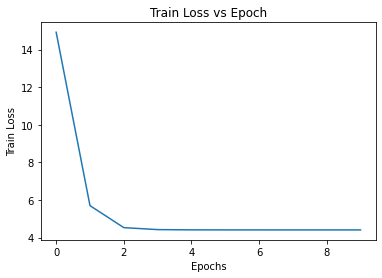

In [ ]:
x = np.arange(10)
plt.plot(x, train_loss_list)
plt.title("Train Loss vs Epoch")
plt.xlabel('Epochs')
plt.ylabel('Train Loss')
plt.savefig('./FinalReportandppt/Plots/train_loss_vs_epochs.png')
plt.show()

<Figure size 432x288 with 0 Axes>

# Testing

In [23]:
X_local_test = np.load('Data/Final_Data_Transformers/final_transformers_local_met_data_test.npz', allow_pickle=True)['arr_0']
X_remote_test = np.load('Data/Final_Data_Transformers/final_transformers_station_metaq_data_test.npz', allow_pickle=True)['arr_0']
y_test = np.load('Data/Final_Data_Transformers/transformers_local_aq_data_test.npz', allow_pickle=True)['arr_0']
y_test = y_test.reshape((-1,))

In [30]:
X_local_test.shape, X_remote_test.shape, y_test.shape

((8628, 24, 30), (8628, 23, 24, 31), (8628,))

In [ ]:
# Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = MyModel(
    dim_model_local=list(X_local.shape[1:]), dim_model_remote=list(X_remote.shape[1:]), num_heads=2, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1
).to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
model.load_state_dict(torch.load('./Model Checkpoints/model_9_epoch.pt'))
model.eval()

In [20]:
def predict(model, X_local, X_remote):
    model.eval()
    X_l, X_r= torch.tensor(X_local).to(device).float(), torch.tensor(X_remote).to(device).float()
    pred = model(X_l, X_r)
    return pred.detach().item()

In [35]:
batched_test_data = batchify_data(X_local_test, X_remote_test, y_test, batch_size=12)

In [36]:
def test_loop(model, loss_fn):
    model.eval()
    total_loss = 0

    preds = []
    for i in tqdm(range(len(batched_test_data))):
        X_l, X_r, y = batched_test_data[i][0], batched_test_data[i][1], batched_test_data[i][2]
        X_l, X_r, y = torch.tensor(X_l).to(device).float(), torch.tensor(X_r).to(device).float(), torch.tensor(y).to(device).float()

        pred = model(X_l, X_r)
        preds.append(pred.detach().numpy().reshape(-1))
    
    preds = np.array(preds)
    preds = preds.flatten()
    total_loss = np.sqrt(mean_squared_error(preds, y_test))
    
    return total_loss

In [37]:
test_loss = test_loop(model, loss_fn)

100%|██████████| 719/719 [00:51<00:00, 14.04it/s]


In [38]:
test_loss

4.36726488614612